# Sentiment classification with spaCy

This notebook focus on the training of sentiment classifier on hotel review dataset. It uses convolutional neural network (CNN) that is trained by internal spaCy function `Language.update()` and `TextCategorizer` component. It builds on the training steps described on https://spacy.io/usage/training#textcat, with these differences:

- uses a different dataset (hotel reviews)
- processes data using padas
- uses seaborn for data exploration
- includes data balancing
- explains batch perparation
- includes model analysis using ROC
- introduces business anlaysis with use of sentiment data

*Author: Filip Venovsky, Prague University of Economics and Business.*

## Create model output directory

In [1]:
from pathlib import Path
output_dir = Path("model_categorizer")
if not output_dir.exists():
    output_dir.mkdir()

## Loading data
We are loading data into `pandas` data frame. Before that, we need to import pandas library. We are using an alias `pd` for easier use.

In [2]:
import pandas as pd

Pandas has function `read_csv` for parsing data from csv file.

Used parametres:
- `"hotel_data.csv"` on the first position, we define the name of the csv file. We don't need to specify the path to the file because it resides on the same place as our notebook.
- `index_col=False` is used because our datafile contains no indexes. As pandas needs indexes, it will add their own incremetnal index.
- `usecols=['stars', 'text']`, the datafile has more columns, we specify only two with review `text` and `starts`. As we work with column names, it can be in any order.
- `dtype={'stars':"string", 'text':"string"})` sets data types of columns (`Series` object). Because, we define it using dictionary, it can be in any order. Possible data types are described in the [dtypes](https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#basics-dtypes) section of the official pandas guide.

If the datafile contains non-standard delimiters, encoding or quoting, we will use additional parametres from [CSV & text files](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-read-csv-table) section of the pandas guide. Parsing of other file types is explained in [IO tools](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html) section of the guide.

Name of the variable `df` at the end of the block causes rendering of a data frame as table.

In [3]:
df = pd.read_csv("hotel_data.csv", 
                 index_col=False, 
                 usecols=['stars', 'text'], 
                 dtype={'stars':"string", 'text':"string"})
df

stars                                               text
0     5 of 5 stars  We were together with some friends at the Anew...
1     4 of 5 stars  Martin and his staff are truely great! They ma...
2     5 of 5 stars  We have stayed at the Excelsior on numerous oc...
3     5 of 5 stars  The great reviews are well deserved. Stayed he...
4     5 of 5 stars  Not sure we can add anything to the accurate r...
...            ...                                                ...
7149  5 of 5 stars  An incredible ride for 10 euros return. Wonder...
7150  5 of 5 stars  Bolzano proper--the old city--takes about a da...
7151  5 of 5 stars  This was the cheapest gondola we had ever ridd...
7152  5 of 5 stars  This cable ride up into the hills is a visual ...
7153  5 of 5 stars  We spent 4 days in Bolzano and were a little c...

[7154 rows x 2 columns]

## Data preparation

Sentiment is usually trained on review data because review text is accompained with rating on an ordinary scale. We are in the same situation. To with with rating as sentimetn categories, we need to:
1. convert textual rating to numbers,
1. convert rating to wider sentiment categories,
1. remove neutral sentiment.

### Convert textual rating to numbers
For conversion of textual rating in this specific format (*5 of 5 stars*) from string to number, we just need to keep the first character and covert the character to number.

`pandas` allows to operate with all strings in one column. Such operation is much faster than iterating over cells and converting each string separately. These string operations in pandas package starts with [`str.`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.html?highlight=str). It is possible to call these function on the `Series` object of string type.

For keeping only the first character, we use `str.slice` method with `stop` parameter and `1` value. This ensures that slicing stops after the first character.

The last operating needed is changing type of column to number (integer), and saving it back to the data frame.

In [4]:
stars = df["stars"].str.slice(stop=1)
stars = stars.astype(int)
df["stars"] = stars
df

stars                                               text
0         5  We were together with some friends at the Anew...
1         4  Martin and his staff are truely great! They ma...
2         5  We have stayed at the Excelsior on numerous oc...
3         5  The great reviews are well deserved. Stayed he...
4         5  Not sure we can add anything to the accurate r...
...     ...                                                ...
7149      5  An incredible ride for 10 euros return. Wonder...
7150      5  Bolzano proper--the old city--takes about a da...
7151      5  This was the cheapest gondola we had ever ridd...
7152      5  This cable ride up into the hills is a visual ...
7153      5  We spent 4 days in Bolzano and were a little c...

[7154 rows x 2 columns]

## Data analysis
From the point where we have numbers in the data frame, we can plot it. Easiest option for plotting data frames is [seaborn](https://seaborn.pydata.org/). As [examples galery](https://seaborn.pydata.org/examples/index.html) or [documentation](https://seaborn.pydata.org/api.html) shows, it offers a lot of possibilities.

In [5]:
import seaborn as sns

Although we converted rating to numbers, the data are rather ordinal than numeric. Thus, we plot them using [`countplot`](https://seaborn.pydata.org/generated/seaborn.countplot.html#seaborn.countplot) that is build to show frequencies of categories.

Parametres:
- `x="stars"` specifies the column with categories for axis x.
- `data=df` specifies data frame, which we have stored in `df` variable.
- `palette` is a color palette of our chart. For other colors, see [matlab colormaps]( https://matplotlib.org/tutorials/colors/colormaps.html).

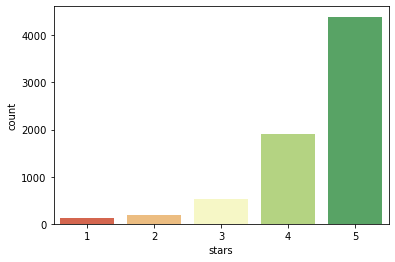

In [6]:
sns.countplot(x="stars", data=df, palette="RdYlGn")

## Conversion to sentiment categories

Learing of sentiment using finer values is harder, so we convert the rating into three bins: `NEGATIVE` (od 0 od 2), `NEUTRAL` (jen 3) a `POSITIVE` (od 4 do 5). Binning is done in padas using [`cut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) function.
As we still work with numerical values, it is important to specify the intervals as open or closed. For details see [documentation of cut function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).

We store the result to a new column called `sentiment`. 

By calling the same `countplot` on the new column, we plot the new distribution.

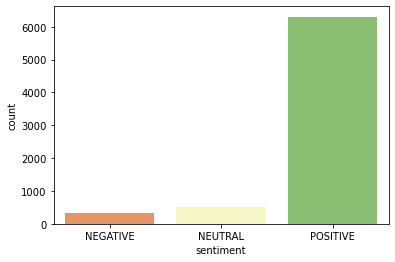

In [7]:
df["sentiment"] = pd.cut(df["stars"], 
                   bins=[0,2.9,3,5], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
sns.countplot(x="sentiment", data=df, palette="RdYlGn")

`cut` function created `sentiment` column as categorial data type. Categorial types are more efficient for bulk operation and counting than strings.

We can explore newly created categories by calling `dtype` funtion on our data frame.

In [8]:
df.sentiment.dtype

CategoricalDtype(categories=['NEGATIVE', 'NEUTRAL', 'POSITIVE'], ordered=True)

For exact counts, we call `groupby` with `count` aggregation. The only parametry for group function is the name of the column.

In [9]:
df.groupby("sentiment").count()

stars  text
sentiment             
NEGATIVE     324   324
NEUTRAL      526   526
POSITIVE    6304  6304

## Removing neutral category

The middle `NEUTRAL` category is not suitable for sentiment training because it contains sentimentally very uneven textual reviews. Therefore, we will remove the netural reviews. To remove the reviews, we need to select them first. 

Rows of a data frame can be filtered using an expression in square paranthesis. Square paranthesis are expexted to contain an expression that will result to a set of boolean values that tells the frame which rows to return. 

In this case, we use column `df.sentiment` followed by equality operator `==` and value 
`NEUTRAL`.

In [10]:
df[df.sentiment == "NEUTRAL"]

stars                                               text sentiment
32        3  Nice suite! Spa was good except for the arroga...   NEUTRAL
111       3  The room was very small, the shower was terrib...   NEUTRAL
143       3  What you are served with is good food no doubt...   NEUTRAL
166       3  This place has a very unusual and traditional ...   NEUTRAL
203       3  Typically baroque and quite interesting. Worth...   NEUTRAL
...     ...                                                ...       ...
7138      3  Is in the center of everything. I have never h...   NEUTRAL
7139      3  You'd go for a beer and a pretzel, but dinner ...   NEUTRAL
7141      3  The beer is nice but the service is just so so...   NEUTRAL
7142      3  Good beer, nice pub-style food, bustling atmos...   NEUTRAL
7143      3  The beer is absolutely tops. Service was lukew...   NEUTRAL

[526 rows x 3 columns]

Finally, the removal of neutral reviews is done by [`drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) function.

Drop function needs as indicies of rows to remove as an input. We convert the previous result to indicies by approaching `index` attribute of the result.

In [11]:
indicies_to_drop = df[df.sentiment == "NEUTRAL"].index

indicies_to_drop

Int64Index([  32,  111,  143,  166,  203,  226,  232,  333,  373,  384,
            ...
            7109, 7115, 7116, 7120, 7121, 7138, 7139, 7141, 7142, 7143],
           dtype='int64', length=526)

`drop` function returns only a copy of modified data frame. To replace our original frame, we need to save it back to the `df` variable.

To inspect our modified data frame, we call again the `groupby` function.

In [12]:
df = df.drop(indicies_to_drop)

df.groupby("sentiment").count()

stars  text
sentiment             
NEGATIVE     324   324
NEUTRAL        0     0
POSITIVE    6304  6304

Since the neutral category stays without reviews, we will remove it from categories by calling `remove_unused_categories` on `cat` attribute of the column.

To inspect our modified data frame, we plot again the chart and print information about sentiment categories.

CategoricalDtype(categories=['NEGATIVE', 'POSITIVE'], ordered=True)

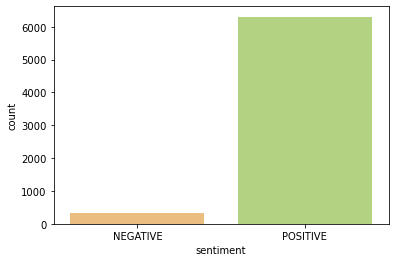

In [13]:
df.sentiment = df.sentiment.cat.remove_unused_categories()
sns.countplot(x="sentiment", data=df, palette="RdYlGn")
df.sentiment.dtype

## Category balancing

Our data has imbalanced occurences in categories. Such imbalance would influence how the model learns to classify reviews.

For balancing, we can use either (a) **weights** during a training, or (b) **oversampling**, see [recommendation on tenserflow](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
 
Because we are limited by spaCy training possibilities (but it's simpler), we balance our model by reducing the number of examples in the bigger category (way of oversampling).

**Method**
- prepare two slices of the original data: one with positive and one with negative reviews
- select a random sample from the larger category in the similar size as the smaller category
- concatenate slices back to one data set

First of all, we prepare slices and store them into two variables `df_neg` and `df_pos`.

In [14]:
df_neg = df[df.sentiment=="NEGATIVE"]
df_pos = df[df.sentiment=="POSITIVE"]

From the larger category, we select a random sample of 500 rows with [`sample`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html?highlight=sample#pandas.DataFrame.sample) function. The only parameter is the number of rows we are going to keep. Alternatively, we can use `frac` parameter which offers proporcional smapling.

In [15]:
df_pos = df_pos.sample(500)

For concatenatation of slices back to one data frame, we use [`concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html?highlight=concat#pandas.concat) function.

Parameters:
- `[df_neg, df_pos]` represents an array of data frames to concatenate. značí pole datových rámců pro zřetězení. It suppose the frames have the same columns. Otherwise, different columns will have empty cells.
- `ignore_index=True` ignores indicies and create a new one.

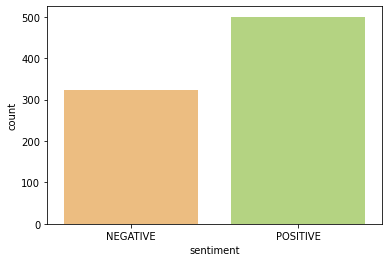

In [16]:
df = pd.concat([df_neg, df_pos], ignore_index=True)
sns.countplot(x="sentiment", data=df, palette="RdYlGn")

## Preparation of category dictionary for training

spaCy expects a dictionary for category training. The dictionary must contain names of categories and their logical values. We prepare the dictionary and save it to a new column called `cats`.

We add an additional column with the dictionary. The easiest way how to do it is to prepare an array with the same length by iterating over the sentiment column. For each item, we compare the value and prepare a dictionary. 

In [17]:
df["cats"] = [{"POSITIVE": y=="POSITIVE", "NEGATIVE": y=="NEGATIVE"} for y in df.sentiment]
df

stars                                               text sentiment  \
0        2  We came at noon. The waiters totally ignored u...  NEGATIVE   
1        2  We have been visiting Fana Ladina since 2008 a...  NEGATIVE   
2        1  Several times was about to try, but unfortunat...  NEGATIVE   
3        2  Very disappointed in this hotel. The appartmen...  NEGATIVE   
4        1  I have been visiting Brixen for some years now...  NEGATIVE   
..     ...                                                ...       ...   
819      4  The Sandlstubele is a nice restaurant with ita...  POSITIVE   
820      4  The bad news first: if you depend on having re...  POSITIVE   
821      4  Really friendly owners and service, lovely foo...  POSITIVE   
822      5  I spent a wonderful week with a bunch of frien...  POSITIVE   
823      5  My friend and I came to Bolzano for the Christ...  POSITIVE   

                                      cats  
0    {'POSITIVE': False, 'NEGATIVE': True}  
1    {'POSITIVE': False, 'NEGATIVE': True}  
2    {'POSITIVE': False, 'NEGATIVE': True}  
3    {'POSITIVE': False, 'NEGATIVE': True}  
4    {'POSITIVE': False, 'NEGATIVE': True}  
..                                     ...  
819  {'POSITIVE': True, 'NEGATIVE': False}  
820  {'POSITIVE': True, 'NEGATIVE': False}  
821  {'POSITIVE': True, 'NEGATIVE': False}  
822  {'POSITIVE': True, 'NEGATIVE': False}  
823  {'POSITIVE': True, 'NEGATIVE': False}  

[824 rows x 4 columns]

## Split data for training nad testing

Before the actual split, we need to shuffle data. For this purpose, we use again the `sample` function with the proportional parametre `frac` and value `1`. This return the same set in random order.

In [18]:
df = df.sample(frac=1) 
df

stars                                               text sentiment  \
414      4  For the last 5 years, we have stayed at the Po...  POSITIVE   
560      4  The Garni Cremona is a very Good and economic ...  POSITIVE   
155      2  I was there in August for 3 days, at work. Not...  NEGATIVE   
450      5  We started a two week holiday here (walking in...  POSITIVE   
95       2  Interesting menu, quality of food not so bad b...  NEGATIVE   
..     ...                                                ...       ...   
215      2  we booked 4 rooms via booking.com with cancela...  NEGATIVE   
268      2  Stopped in for lunch on our last day in Bolzan...  NEGATIVE   
731      4  We have spent a weekend in this hotel, we book...  POSITIVE   
631      4  The place of Bolzano to watch the intersection...  POSITIVE   
776      5  this is really a jewel. A beautiful, quiet loc...  POSITIVE   

                                      cats  
414  {'POSITIVE': True, 'NEGATIVE': False}  
560  {'POSITIVE': True, 'NEGATIVE': False}  
155  {'POSITIVE': False, 'NEGATIVE': True}  
450  {'POSITIVE': True, 'NEGATIVE': False}  
95   {'POSITIVE': False, 'NEGATIVE': True}  
..                                     ...  
215  {'POSITIVE': False, 'NEGATIVE': True}  
268  {'POSITIVE': False, 'NEGATIVE': True}  
731  {'POSITIVE': True, 'NEGATIVE': False}  
631  {'POSITIVE': True, 'NEGATIVE': False}  
776  {'POSITIVE': True, 'NEGATIVE': False}  

[824 rows x 4 columns]

We set the proportion of 80% training and 20% of testing data. We need to find the index of the dividing row (`split_row`)

In [19]:
split = 0.8
split_row = int(len(df) * split)
split_row

659

With dividing row, we split our data frame using expression in square paranthesis and a colon. The position of the colon against the `split_row` variable defines which part of the data frame is being stored in a `df_test` or `df_train` variable.

For validation, we print the length of the splitted frames.

In [20]:
df_test = df[split_row:]

len(df_test)

165

In [21]:
df_train = df[:split_row]

len(df_train)

659

## Data format for spaCy `update` and `evaluate` funcions
spaCy [`update`](https://spacy.io/api/textcategorizer#update) funcion of the [`TextCategorizer`](https://spacy.io/api/textcategorizer) object expects a collection of touples with text and category labels (stored in the dictionary).

In [22]:
train_data = list(zip(df_train["text"], [{"cats": cats} for cats in df_train["cats"]]))
test_data = list(zip(df_test["text"], [{"cats": cats} for cats in df_test["cats"]]))

train_data[:3]

[('For the last 5 years, we have stayed at the Post Gries for a brief overnight stop on our way to skiing in Val Gardena. Although we often arrive past midnight, ther has always been an immediate and efficient welcome - cars in the secure garage and in ourquiet, comfortable rooms within 15 minutes! The breakfast has always been excellent and the checkout fast and efficient. by very helpful staff.',
  {'cats': {'POSITIVE': True, 'NEGATIVE': False}}),
 ("The Garni Cremona is a very Good and economic Garni near to the Brixen Raylway Station and about 15 mins on foot to the city centre. The Garni is very clean and new and also the rooms and the bathrooms are very clean and new! In the room there is a new tv with italian, german and austria channels! The pirce is very good!! We'll came back in these Garni!! The Bad things: the Breakfast!! The staff is very kind",
  {'cats': {'POSITIVE': True, 'NEGATIVE': False}}),
 ('I was there in August for 3 days, at work. Not a good hotel for people who

## Loading the language model

In [23]:
import spacy
nlp = spacy.load("en_core_web_md")

## Creation of a new sentiment classifier

We crate a new pipeline component using [`nlp.create_pipe`](https://spacy.io/api/language#create_pipe).

Parameters:
- ID of the classifier is on the first position. TextCategorizer class instances have always ID `textcat`.
- Configuration:
  - `exclusive_classes`, logical value that defines whether categories/classes are exlusive. Positive and negative sentiment values are exlusive, so we use `True`.
  - `architecture`, we can choose from a couple of options described in the [TextCategorizer documentation](https://spacy.io/api/textcategorizer#architectures). In this example, we use simple convolutional network `simple_cnn`.

In [24]:
textcat = nlp.create_pipe("textcat",
                          config={"exclusive_classes": True,
                                  "architecture": "simple_cnn"})

We add the new pipe into the loaded model pipeline using [`nlp.add_pipe`](https://spacy.io/api/language#add_pipe). Parameter `last` specifies the end position where the classifier should be placed in the pipeline.

In [25]:
nlp.add_pipe(textcat, last=True)

We put `POSITIVE` and `NEGATIVE` categories as lables into the newly created classifier pipe.

In [26]:
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

textcat.labels # print labels

('POSITIVE', 'NEGATIVE')

## Batch preparation

For model training, it is necessary to decide how a model should walk trough examples in a training set.  The main point to consider is when a model updates its parametres.

There are at least three possibilities:
- Model updates parametres after seeing all examples in the training set (*batch*). It is more precise, but also more resource intensive and slow to get the first results.
- Model updates parametres after seeing one single example (*stochastic*). It offer faster results, but is less precise and comes with the risk of oscilation around the local minima.
- A combination of previous (*minibatch*), it is possible to set a specific number of examples in a batch. Batches can also have different sizes in one training.

spaCy has two functions for batch preparation:
- [`compouding`](https://spacy.io/api/top-level#util.compounding ) for batch size,
- [`minibatch`](https://spacy.io/api/top-level#util.minibatch) for batch itself.

It is useful to rise the batch size during a training (see [tips in documentation](https://spacy.io/usage/training#tips-batch-size)). For classifier training, it is possible to start on bigger sizes.

In [27]:
from spacy.util import minibatch, compounding

In [28]:
# for example
batch_sizes = compounding(1.0, 32.0, 1.5)
for x in range(12): print(next(batch_sizes))

1.0
1.5
2.25
3.375
5.0625
7.59375
11.390625
17.0859375
25.62890625
32.0
32.0
32.0


After repeted calling of `batch_sizes`, results would be the same size hiest value, so we need to prepare iterator again for each new use.

Except `compunding`, `minibatch` function is used for preparation of set of examples in the size determined by compounding iterator.

For example:

In [29]:
batch_sizes = compounding(1.0, 4.0, 1.5)
for batch in minibatch(train_data[1:5], size=batch_sizes):
    print("\nbatch:", len(batch), batch)


batch: 1 [("The Garni Cremona is a very Good and economic Garni near to the Brixen Raylway Station and about 15 mins on foot to the city centre. The Garni is very clean and new and also the rooms and the bathrooms are very clean and new! In the room there is a new tv with italian, german and austria channels! The pirce is very good!! We'll came back in these Garni!! The Bad things: the Breakfast!! The staff is very kind", {'cats': {'POSITIVE': True, 'NEGATIVE': False}})]

batch: 1 [('I was there in August for 3 days, at work. Not a good hotel for people who want to work, since the internet does not work outsider the lobby. Staff not very nice, I got the impression they only pay attention to German guests, but Italians and others (like me, Portugueses), hardly exist. The food was ok, but this hotel should not be considered a 4*, in my opinion. Also, the bathroom in the bedroom was extremely small and the room was not cleaned, although the cleaning lady went in, she did not even notice 

## Training

### Training cycles

Model training run in two embedded cycles:
1. iterations over the whole training sets (epochs) `for i in range(n_iter)`
1. iteration over batches in a training set `for batch in batches`

Let's set the number of iterations over the training set as a variable `n_iter`.

In [30]:
n_iter = 10

### Schuffle examples

For every interation, we need to shuffle examples so the model sees them in a different order/different batches. We will use `random.shuffle()` function from `random` library.

In [31]:
import random

### Dropout rate
spaCy allows to set a **dropout rate**. In this case, we choose a higher droptout rate due to lower number of examples that may cause overfitting of our model.

See comment from the documentation:
>Another technique to improve the learning results is to set a dropout rate, a rate at which to randomly “drop” individual features and representations. This makes it harder for the model to memorize the training data. For example, a 0.25 dropout means that each feature or internal representation has a 1/4 likelihood of being dropped.

In [32]:
dropout = 0.7

### Removal of other pipes
While training a new clasifier, we need to remove temporalily other pipes of the language model.
>If you’re using an existing model, make sure to disable all other pipeline components during training using [nlp.disable_pipes](https://spacy.io/api/language#disable_pipes)

In [33]:
# get names of other pipes to disable them during training
pipe_exceptions = ["textcat"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
other_pipes

['tagger', 'parser', 'ner']

### Construction using `with`
In the training block, we will use python construction `with` that allows us to
- work **temporarily** without removed pipes `with nlp.disable_pipes(other_pipes)`
- use **temporarily** updated model for evaluation purpose `with textcat.model.use_params(optimizer.averages)`

### Model evaluation

After each iteration, we will evaluate our model on the other part of data (`test_data` variable) which we set aside before training in the same format as training data.

For evaluation purpose, spaCy offers [`Scorer`](https://spacy.io/api/scorer) class. We don't need to create an instance of the class, because our training function `nlp.update` returns one.

[`Scorer`](https://spacy.io/api/scorer) has these [attributes](https://spacy.io/api/scorer#properties) relevant to class learning:
- dictionary `scores` of all scores ordered by type,
- value `textcat_score` represents F-score for exlusive classes learning (our case),
- dictionary `textcat_per_cat` per each category/class. Each class has
  - `p` **precision**, 
  - `r` **recall**,
  - `f` **F-score**.
  
Besides [`Scorer`](https://spacy.io/api/scorer), we follow the final result of loss function which is stored after each call of `nlp.update` into `losses` variable.

To study model quality more in depth, we try evaluation functions from `sklearn` library. It offers, for example, ROC (Receiver Operating Characteristic) curve with AUC metric.
>ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

>The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

In [34]:
from sklearn import metrics # scoring functions
import numpy as np # for random numbers generation

ROC curve can be returned by [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) function, where the first paramter `y` represent training data, second parametr predicted data. `pos_label` allows to set a value which corresponds with matching `1` value.

#### How would ROC curve looks like a for random guess?

In [35]:
y = df_test["sentiment"] # ["POSITIVE", "NEGATIVE", "POSITIVE", "NEGATIVE", ...]
random_scores = np.random.rand(len(df_test.sentiment)) # random score from 0 (NEGATIVE) to 1 (POSITIVE)

fpr, tpr, thresholds = metrics.roc_curve(y, random_scores, pos_label="POSITIVE") # ROC calculation

We calculate AUC score from the results of `roc_curve` by calling [`auc`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [36]:
metrics.auc(fpr, tpr)

0.490952380952381

Plotting a chart using `seaborn` library and `lineplot` function.

In [37]:
plot = sns.lineplot(x=fpr, y=tpr, linewidth=2.5)
plot.set(xlabel='False Positive', ylabel='True Positive')

[Text(0, 0.5, 'True Positive'), Text(0.5, 0, 'False Positive')]

### Bulk document parsing
Model evation needs to load a process a large number of texts. If we don't use `evaluate` function, it is better to process example texts with `Language.pipe` function. The function uses bulk processing and it is possible to tune it by batch size and process paralelisation.

The `pipe` function returns generation that can be used as a parametr for a `list` function to get list of parsed documents.

### Training code

In [38]:
score = pd.DataFrame() # dataframe for results
print("training", end="") # print of progress

with nlp.disable_pipes(other_pipes):  # with temporarily disabled pipes
    
    optimizer = nlp.begin_training() # storing our training optimizer
    
    for i in range(n_iter): # iteration over the whole training set (epoch)
        print(".", end="") # print of progress
        losses = {} # variable for storing model performance (losses)
        random.shuffle(train_data) # shuffle the training set
        
        batch_sizes = compounding(8.0, 40.0, 1.2) # preparation of batch sizes
        batches = minibatch(train_data, size=batch_sizes) # preparation of batches
        
        for batch in batches: # iteration over batches
            texts, annotations = zip(*batch) # unzipping touples into separate variables
            
            nlp.update(texts, annotations, sgd=optimizer, drop=dropout, losses=losses) # learning
            
        # following code is only for model evaluation
        
        with textcat.model.use_params(optimizer.averages): # with temp model update
            scorer = nlp.evaluate(test_data) # model evaluation using built-in function
            
            # filling our table with trainnig progress
            score.loc[i, "loss"] = losses["textcat"] # filling final loss of an iteration
            score.loc[i,"F"] = scorer.textcat_score            
            score.loc[i,"P+"] = scorer.textcats_per_cat["POSITIVE"]["p"]
            score.loc[i,"R+"] = scorer.textcats_per_cat["POSITIVE"]["r"]
            score.loc[i,"F+"] = scorer.textcats_per_cat["POSITIVE"]["f"]
            score.loc[i,"P-"] = scorer.textcats_per_cat["NEGATIVE"]["p"]
            score.loc[i,"R-"] = scorer.textcats_per_cat["NEGATIVE"]["r"]
            score.loc[i,"F-"] = scorer.textcats_per_cat["NEGATIVE"]["f"]
            
            # alternative scoring using ROC and sklearn library
            docs_generator = nlp.pipe(df_test["text"]) # bulk processing of test examples
            docs = list(docs_generator) # loading of parsed documents into a list
            scores = [doc.cats["POSITIVE"] for doc in docs] # loading predicted sentiment into a list
            
            # ROC calculation
            fpr, tpr, thresholds = metrics.roc_curve(y_true = df_test["sentiment"], 
                                                     y_score = scores, 
                                                     pos_label = "POSITIVE")
            
            # filling our table AUC score
            score.loc[i,"AUC"] = metrics.auc(fpr, tpr)
            
score # display of our table with training progress

training..........

loss          F         P+          R+         F+          P-  \
0  0.031382  38.888889  63.636364  100.000000  77.777778    0.000000   
1  0.029172  38.888889  63.636364  100.000000  77.777778    0.000000   
2  0.027694  40.672802  64.024390  100.000000  78.066914  100.000000   
3  0.023360  84.922327  94.505495   81.904762  87.755102   74.324324   
4  0.021019  85.584046  95.555556   81.904762  88.205128   74.666667   
5  0.017668  85.377054  88.073394   91.428571  89.719626   83.928571   
6  0.031833  87.373737  95.698925   84.761905  89.898990   77.777778   
7  0.015533  87.765854  93.000000   88.571429  90.731707   81.538462   
8  0.017036  88.576923  95.789474   86.666667  91.000000   80.000000   
9  0.015219  88.091168  97.777778   83.809524  90.256410   77.333333   

          R-         F-       AUC  
0   0.000000   0.000000  0.812381  
1   0.000000   0.000000  0.913175  
2   1.666667   3.278689  0.913968  
3  91.666667  82.089552  0.934444  
4  93.333333  82.962963  0.943810  
5  78.333333  81.034483  0.947619  
6  93.333333  84.848485  0.953492  
7  88.333333  84.800000  0.953968  
8  93.333333  86.153846  0.959365  
9  96.666667  85.925926  0.963651

### Plotting ROC for the final model

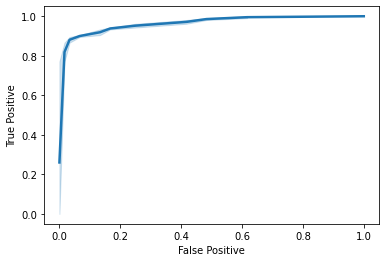

In [39]:
docs_generator = nlp.pipe(df_test["text"]) # bulk processing of test examples
docs = list(docs_generator)  # loading of parsed documents into a list
scores = [doc.cats["POSITIVE"] for doc in docs] # loading predicted sentiment into a list

# ROC calculation
fpr, tpr, thresholds = metrics.roc_curve(y_true = df_test["sentiment"], 
                                         y_score = scores, 
                                         pos_label = "POSITIVE")

# plotting ROC chart
roc_plot = sns.lineplot(x=fpr, y=tpr, linewidth=2.5)
roc_plot.set(xlabel='False Positive', ylabel='True Positive')
roc_plot

Only after storing our model on disc, we can repeatedly load and use the model.

While storing we will use parameters averging by calling `use_params` with `optimizer.averages`.
>The last part of our optimization recipe is parameter averaging, an old trick introduced by Freund and Schapire (1999), popularized in the NLP community by Collins (2002), and explained in more detail by Leon Bottou. Just about the only other people who seem to be using this for neural network training are the SyntaxNet team (one of whom is Michael Collins) – but it really seems to work great on every problem.

In [40]:
with nlp.use_params(optimizer.averages):
    nlp.to_disk(output_dir)
print("Saved model to", output_dir)

Saved model to model_categorizer


## Trying our model
We can try our newly trained model on a set of brand new texts. For that, we prepare a new data frame.

In [41]:
examples = pd.DataFrame(["The rooms were clean.", "They went over and beyond to help make our stay enjoyable.",
                         "The breakfast is one of the best I have ever had in Europe.",
                         "I highly recommend this hotel for anyone visiting downtown", 
                         "We got to hotel super early", "The sevice was exceptional as well.",
                         "Every staff member I encountered were delightful and eager to help!",
                         "The bed was extremely comfortable.", "The room was spacious and clean.",
                         "Beautiful atmosphere inside and outside around that part of the city.",
                         "Everything what you need is possible.", "The room was huge, modern, and spotless.",
                         "This is a beautiful hotel!", "The environment was pleasant and welcoming.",
                         "We could park our motorcycles in the closed garage.", "Great value for money.",
                         "Must definitelly recommend breakfast, good food and variety of it.",
                         "Hot water constantly running out.", "Virtually no cooking utensils",
                         "Beds were extremely uncomfortable", "Pillows were solid hurting your neck when you slept.",
                         "My kid broke his arm there.", "Worst hotel I've stayed in.", "No Wi-Fi inside rooms.",
                         "Fridge was dirty and horrible and the bottom of it was rusty.", "Back-pain guaranteed.",
                         "Only way to let some fresh air inside is to open the main door.", 
                         "Limited hot water in apartments", "Barely slept all week.", 
                         "Staff are extremely rude and unhelpful", "Majority of hotel staff were miserable",
                         "Rooms smelt of cheap air freshener in an attempt to cover up a bad smell.",
                         "Furniture was cheap and didn't match (not a big deal)", "Smells very very ugly from bathroom.",
                         "standards were below what we were expecting."
                        ], 
                        columns=["text"])
examples

text
0                               The rooms were clean.
1   They went over and beyond to help make our sta...
2   The breakfast is one of the best I have ever h...
3   I highly recommend this hotel for anyone visit...
4                         We got to hotel super early
5                 The sevice was exceptional as well.
6   Every staff member I encountered were delightf...
7                  The bed was extremely comfortable.
8                    The room was spacious and clean.
9   Beautiful atmosphere inside and outside around...
10              Everything what you need is possible.
11           The room was huge, modern, and spotless.
12                         This is a beautiful hotel!
13        The environment was pleasant and welcoming.
14  We could park our motorcycles in the closed ga...
15                             Great value for money.
16  Must definitelly recommend breakfast, good foo...
17                  Hot water constantly running out.
18                      Virtually no cooking utensils
19                  Beds were extremely uncomfortable
20  Pillows were solid hurting your neck when you ...
21                        My kid broke his arm there.
22                        Worst hotel I've stayed in.
23                             No Wi-Fi inside rooms.
24  Fridge was dirty and horrible and the bottom o...
25                              Back-pain guaranteed.
26  Only way to let some fresh air inside is to op...
27                    Limited hot water in apartments
28                             Barely slept all week.
29             Staff are extremely rude and unhelpful
30             Majority of hotel staff were miserable
31  Rooms smelt of cheap air freshener in an attem...
32  Furniture was cheap and didn't match (not a bi...
33               Smells very very ugly from bathroom.
34       standards were below what we were expecting.

It is not efficient to iterate over rows of a data frame in a loop. Pandas library has [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) function that works faster. 

[`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) parameters:
- function name, for example aggregation function such as `np.sum`
- `axis` on which apply will operate
  - `0` for application on columns
  - `1` for application on rows
- arguments of called function

We create a new function called `evaluate` that we will use with [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html). As parameters, we will excpect dataframe row `row` and a language model `nlp` that returns value in the sentiment category.

To the row (from parameter), we add a new column `sentiment_score` where we store predicted sentiment value. It is sufficient to store `POSITIVE` sentiment value because the classes are exclusive.

In [42]:
def evaluate(row, nlp=nlp):
    row["sentiment_score"]=nlp(row["text"]).cats["POSITIVE"]    
    return row

If we need to work with the predicted sentiment as category, we could again use pandas function `pd.cut` witch creates categories according to specified bins.

In [43]:
examples = examples.apply(evaluate, nlp=nlp, axis=1)

examples["sentiment"] = pd.cut(examples["sentiment_score"], 
                   bins=[0,0.4,0.6,1], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])


### Trying our model from disc
To try our model stored on disc, we load the model from the folder using `spacy.load` function.

In [44]:
# test the saved model
nlp_disk = spacy.load(output_dir)

We duplicate the frame with examples and use our `evaluate` function, this time with the model loaded from folder.

In [45]:
examples_disk = examples.copy()
examples_disk = examples_disk.apply(evaluate, nlp=nlp_disk, axis=1)
examples_disk["sentiment"] = pd.cut(examples_disk["sentiment_score"], 
                   bins=[0,0.4,0.6,1], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
examples_disk

text  sentiment_score  \
0                               The rooms were clean.         0.999879   
1   They went over and beyond to help make our sta...         0.391693   
2   The breakfast is one of the best I have ever h...         0.725909   
3   I highly recommend this hotel for anyone visit...         0.999538   
4                         We got to hotel super early         0.793673   
5                 The sevice was exceptional as well.         0.999353   
6   Every staff member I encountered were delightf...         0.994468   
7                  The bed was extremely comfortable.         0.999634   
8                    The room was spacious and clean.         0.999903   
9   Beautiful atmosphere inside and outside around...         0.999411   
10              Everything what you need is possible.         0.010348   
11           The room was huge, modern, and spotless.         0.999883   
12                         This is a beautiful hotel!         0.999963   
13        The environment was pleasant and welcoming.         0.999980   
14  We could park our motorcycles in the closed ga...         0.969885   
15                             Great value for money.         0.998404   
16  Must definitelly recommend breakfast, good foo...         0.999696   
17                  Hot water constantly running out.         0.417881   
18                      Virtually no cooking utensils         0.018268   
19                  Beds were extremely uncomfortable         0.688756   
20  Pillows were solid hurting your neck when you ...         0.040808   
21                        My kid broke his arm there.         0.001285   
22                        Worst hotel I've stayed in.         0.121585   
23                             No Wi-Fi inside rooms.         0.999670   
24  Fridge was dirty and horrible and the bottom o...         0.003681   
25                              Back-pain guaranteed.         0.938591   
26  Only way to let some fresh air inside is to op...         0.105099   
27                    Limited hot water in apartments         0.893929   
28                             Barely slept all week.         0.425784   
29             Staff are extremely rude and unhelpful         0.964003   
30             Majority of hotel staff were miserable         0.765483   
31  Rooms smelt of cheap air freshener in an attem...         0.000730   
32  Furniture was cheap and didn't match (not a bi...         0.000362   
33               Smells very very ugly from bathroom.         0.993018   
34       standards were below what we were expecting.         0.000371   

   sentiment  
0   POSITIVE  
1   NEGATIVE  
2   POSITIVE  
3   POSITIVE  
4   POSITIVE  
5   POSITIVE  
6   POSITIVE  
7   POSITIVE  
8   POSITIVE  
9   POSITIVE  
10  NEGATIVE  
11  POSITIVE  
12  POSITIVE  
13  POSITIVE  
14  POSITIVE  
15  POSITIVE  
16  POSITIVE  
17   NEUTRAL  
18  NEGATIVE  
19  POSITIVE  
20  NEGATIVE  
21  NEGATIVE  
22  NEGATIVE  
23  POSITIVE  
24  NEGATIVE  
25  POSITIVE  
26  NEGATIVE  
27  POSITIVE  
28   NEUTRAL  
29  POSITIVE  
30  POSITIVE  
31  NEGATIVE  
32  NEGATIVE  
33  POSITIVE  
34  NEGATIVE

## Business analysis
In real life, it is not enough to classify text into categories. The main benefit lies in connection with other categorial data that together creates a new context. Although it is far from real life, we will randomly assign a hotel name to each text.

In [46]:
import numpy as np
random_hotels = np.random.choice(["Marriott", "Hilton", "Intercontinental"], 
                                 size=len(examples.index))

examples.loc[:,"hotel"] = pd.Series(random_hotels, dtype="category")
examples

text  sentiment_score  \
0                               The rooms were clean.         0.999900   
1   They went over and beyond to help make our sta...         0.309188   
2   The breakfast is one of the best I have ever h...         0.353049   
3   I highly recommend this hotel for anyone visit...         0.999248   
4                         We got to hotel super early         0.764098   
5                 The sevice was exceptional as well.         0.998523   
6   Every staff member I encountered were delightf...         0.996371   
7                  The bed was extremely comfortable.         0.999038   
8                    The room was spacious and clean.         0.999853   
9   Beautiful atmosphere inside and outside around...         0.999188   
10              Everything what you need is possible.         0.001172   
11           The room was huge, modern, and spotless.         0.999847   
12                         This is a beautiful hotel!         0.999982   
13        The environment was pleasant and welcoming.         0.999994   
14  We could park our motorcycles in the closed ga...         0.909676   
15                             Great value for money.         0.988948   
16  Must definitelly recommend breakfast, good foo...         0.999788   
17                  Hot water constantly running out.         0.058780   
18                      Virtually no cooking utensils         0.001649   
19                  Beds were extremely uncomfortable         0.199137   
20  Pillows were solid hurting your neck when you ...         0.005210   
21                        My kid broke his arm there.         0.000140   
22                        Worst hotel I've stayed in.         0.027655   
23                             No Wi-Fi inside rooms.         0.999654   
24  Fridge was dirty and horrible and the bottom o...         0.000236   
25                              Back-pain guaranteed.         0.853005   
26  Only way to let some fresh air inside is to op...         0.012385   
27                    Limited hot water in apartments         0.035752   
28                             Barely slept all week.         0.221957   
29             Staff are extremely rude and unhelpful         0.857725   
30             Majority of hotel staff were miserable         0.422505   
31  Rooms smelt of cheap air freshener in an attem...         0.000060   
32  Furniture was cheap and didn't match (not a bi...         0.000037   
33               Smells very very ugly from bathroom.         0.977981   
34       standards were below what we were expecting.         0.000030   

   sentiment             hotel  
0   POSITIVE  Intercontinental  
1   NEGATIVE  Intercontinental  
2   NEGATIVE            Hilton  
3   POSITIVE          Marriott  
4   POSITIVE          Marriott  
5   POSITIVE          Marriott  
6   POSITIVE          Marriott  
7   POSITIVE  Intercontinental  
8   POSITIVE  Intercontinental  
9   POSITIVE  Intercontinental  
10  NEGATIVE  Intercontinental  
11  POSITIVE            Hilton  
12  POSITIVE          Marriott  
13  POSITIVE  Intercontinental  
14  POSITIVE            Hilton  
15  POSITIVE  Intercontinental  
16  POSITIVE            Hilton  
17  NEGATIVE          Marriott  
18  NEGATIVE  Intercontinental  
19  NEGATIVE  Intercontinental  
20  NEGATIVE  Intercontinental  
21  NEGATIVE            Hilton  
22  NEGATIVE  Intercontinental  
23  POSITIVE            Hilton  
24  NEGATIVE  Intercontinental  
25  POSITIVE  Intercontinental  
26  NEGATIVE            Hilton  
27  NEGATIVE            Hilton  
28  NEGATIVE          Marriott  
29  POSITIVE            Hilton  
30   NEUTRAL  Intercontinental  
31  NEGATIVE  Intercontinental  
32  NEGATIVE            Hilton  
33  POSITIVE            Hilton  
34  NEGATIVE  Intercontinental

To verify our hotel cateogry, we print column data type.

In [47]:
examples.hotel.dtype

CategoricalDtype(categories=['Hilton', 'Intercontinental', 'Marriott'], ordered=False)

### Data visualisation
One of the methdos of exploration is data visualisation. We will plot frequency of each sentiment category for each hotel with use of [seaborn](https://seaborn.pydata.org/) library and our known `countplot` function.

Because we needs to plot more dimensions than last time, we will use a legend. We set the name of the column via `hue` parameter.

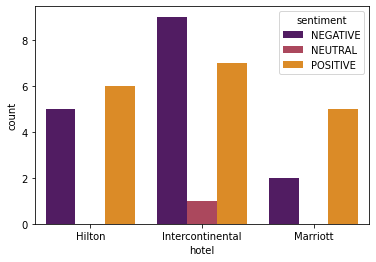

In [48]:
sns.countplot(x="hotel", hue="sentiment", data=examples, palette="inferno")

### Pivot table

Categorial data allows efficient operatoins such as aggregations used in groups or pivot. See [categorial data operations](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#operations) in pandas documentation.

[`pivot_table`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html#pandas-dataframe-pivot-table) function requires just a couple of parametres:
- data frame on the first position,
- `values` as a column with values,
- `aggfunc` aggregation function that will by applied on values,
- `margins` if we want summarisation row
- `index` with column (or array of columns) that will act as table index

In [49]:
pd.pivot_table(examples, 
               values="sentiment_score", 
               aggfunc=["mean", "min", "max"], 
               index="hotel", 
               margins=True)

mean             min             max
                 sentiment_score sentiment_score sentiment_score
hotel                                                           
Hilton                  0.558730        0.000037        0.999847
Intercontinental        0.459222        0.000030        0.999994
Marriott                0.719851        0.058780        0.999982
All                     0.542622        0.000030        0.999994

...or with sentiment categoris as another index column.

In [50]:
pd.pivot_table(examples, 
               values=["sentiment_score", "sentiment"], 
               aggfunc={"sentiment_score":"mean", "sentiment":"count"}, 
               index=["hotel", "sentiment"],
               margins=True)

sentiment  sentiment_score
hotel            sentiment                            
Hilton           NEGATIVE           5         0.080273
                 NEUTRAL            0              NaN
                 POSITIVE           6         0.957445
Intercontinental NEGATIVE           9         0.060482
                 NEUTRAL            1         0.422505
                 POSITIVE           7         0.977132
Marriott         NEGATIVE           2         0.140368
                 NEUTRAL            0              NaN
                 POSITIVE           5         0.951644
All                                35         0.542622

### Correlation matrix
In pandas, we can easily prepare correlation matrix using [`corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) function.

For illustration purpose, we create a new column with random scores.

In [51]:
random_scores = np.random.rand(len(examples.index))

examples.loc[:,"rand_score"] = pd.Series(random_scores, dtype="float")
examples

text  sentiment_score  \
0                               The rooms were clean.         0.999900   
1   They went over and beyond to help make our sta...         0.309188   
2   The breakfast is one of the best I have ever h...         0.353049   
3   I highly recommend this hotel for anyone visit...         0.999248   
4                         We got to hotel super early         0.764098   
5                 The sevice was exceptional as well.         0.998523   
6   Every staff member I encountered were delightf...         0.996371   
7                  The bed was extremely comfortable.         0.999038   
8                    The room was spacious and clean.         0.999853   
9   Beautiful atmosphere inside and outside around...         0.999188   
10              Everything what you need is possible.         0.001172   
11           The room was huge, modern, and spotless.         0.999847   
12                         This is a beautiful hotel!         0.999982   
13        The environment was pleasant and welcoming.         0.999994   
14  We could park our motorcycles in the closed ga...         0.909676   
15                             Great value for money.         0.988948   
16  Must definitelly recommend breakfast, good foo...         0.999788   
17                  Hot water constantly running out.         0.058780   
18                      Virtually no cooking utensils         0.001649   
19                  Beds were extremely uncomfortable         0.199137   
20  Pillows were solid hurting your neck when you ...         0.005210   
21                        My kid broke his arm there.         0.000140   
22                        Worst hotel I've stayed in.         0.027655   
23                             No Wi-Fi inside rooms.         0.999654   
24  Fridge was dirty and horrible and the bottom o...         0.000236   
25                              Back-pain guaranteed.         0.853005   
26  Only way to let some fresh air inside is to op...         0.012385   
27                    Limited hot water in apartments         0.035752   
28                             Barely slept all week.         0.221957   
29             Staff are extremely rude and unhelpful         0.857725   
30             Majority of hotel staff were miserable         0.422505   
31  Rooms smelt of cheap air freshener in an attem...         0.000060   
32  Furniture was cheap and didn't match (not a bi...         0.000037   
33               Smells very very ugly from bathroom.         0.977981   
34       standards were below what we were expecting.         0.000030   

   sentiment             hotel  rand_score  
0   POSITIVE  Intercontinental    0.095438  
1   NEGATIVE  Intercontinental    0.515037  
2   NEGATIVE            Hilton    0.651916  
3   POSITIVE          Marriott    0.359523  
4   POSITIVE          Marriott    0.190980  
5   POSITIVE          Marriott    0.586983  
6   POSITIVE          Marriott    0.782386  
7   POSITIVE  Intercontinental    0.938368  
8   POSITIVE  Intercontinental    0.614498  
9   POSITIVE  Intercontinental    0.446122  
10  NEGATIVE  Intercontinental    0.244723  
11  POSITIVE            Hilton    0.814934  
12  POSITIVE          Marriott    0.925159  
13  POSITIVE  Intercontinental    0.723862  
14  POSITIVE            Hilton    0.002590  
15  POSITIVE  Intercontinental    0.823701  
16  POSITIVE            Hilton    0.992857  
17  NEGATIVE          Marriott    0.260748  
18  NEGATIVE  Intercontinental    0.336499  
19  NEGATIVE  Intercontinental    0.572605  
20  NEGATIVE  Intercontinental    0.854463  
21  NEGATIVE            Hilton    0.564245  
22  NEGATIVE  Intercontinental    0.052210  
23  POSITIVE            Hilton    0.657911  
24  NEGATIVE  Intercontinental    0.852015  
25  POSITIVE  Intercontinental    0.533861  
26  NEGATIVE            Hilton    0.937263  
27  NEGATIVE            Hilton    0.750199  
28  NEGATIVE          Marriott    0.986692  
29  POSITIVE            Hilton    

With prepared scores to correlate, we just call [`corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) on our data frame. As the first parameter, we can choose a concrete correlation method.
>Method of correlation:
>- pearson : standard correlation coefficient
>- kendall : Kendall Tau correlation coefficient
>- spearman : Spearman rank correlation

In [52]:
examples.corr()

sentiment_score  rand_score
sentiment_score         1.000000    0.096572
rand_score              0.096572    1.000000